# FORECASTING EXCHANGE RATES USING TIME SERIES ANALYSIS
Objective:
Leverage ARIMA and Exponential Smoothing techniques to forecast future exchange rates based on historical data provided in the exchange_rate.csv dataset. 
Dataset:
The dataset contains historical exchange rate with each column representing a different currency rate over time. The first column indicates the date, and second column represent exchange rates USD to Australian Dollar.
Part 1: Data Preparation and Exploration
1.	Data Loading: Load the exchange_rate.csv dataset and parse the date column appropriately.
2.	Initial Exploration: Plot the time series for currency to understand their trends, seasonality, and any anomalies.
3.	Data Preprocessing: Handle any missing values or anomalies identified during the exploration phase.
Part 2: Model Building - ARIMA
1.	Parameter Selection for ARIMA: Utilize ACF and PACF plots to estimate initial parameters (p, d, q) for the ARIMA model for one or more currency time series.
2.	Model Fitting: Fit the ARIMA model with the selected parameters to the preprocessed time series.
3.	Diagnostics: Analyze the residuals to ensure there are no patterns that might indicate model inadequacies.
4.	Forecasting: Perform out-of-sample forecasting and visualize the predicted values against the actual values.
Part 3: Model Building - Exponential Smoothing
1.	Model Selection: Depending on the time series characteristics, choose an appropriate Exponential Smoothing model (Simple, Holt’s Linear, or Holt-Winters).
2.	Parameter Optimization: Use techniques such as grid search or AIC to find the optimal parameters for the smoothing levels and components.
3.	Model Fitting and Forecasting: Fit the chosen Exponential Smoothing model and forecast future values. Compare these forecasts visually with the actual data.
Part 4: Evaluation and Comparison
1.	Compute Error Metrics: Use metrics such as MAE, RMSE, and MAPE to evaluate the forecasts from both models.
2.	Model Comparison: Discuss the performance, advantages, and limitations of each model based on the observed results and error metrics.
3.	Conclusion: Summarize the findings and provide insights on which model(s) yielded the best performance for forecasting exchange rates in this dataset.
Deliverables:
•	Include visualizations and explanations for the choices and findings at each step.
•	Well-commented Python code that used to conduct the analysis and build the models.
Assessment Criteria:
•	Accuracy and completeness of the data preparation and exploration steps.
•	Justification for model selection and parameter tuning decisions.
•	Clarity and depth of the analysis in the diagnostics and model evaluation stages.
This assignment offers a hands-on experience with real-world data, applying sophisticated time series forecasting methods to predict future currency exchange rates.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 5)

In [2]:
df = pd.read_csv('exchange_rate.csv')

In [3]:
df.head(5)

date  Ex_rate
0  01-01-1990 00:00   0.7855
1  02-01-1990 00:00   0.7818
2  03-01-1990 00:00   0.7867
3  04-01-1990 00:00   0.7860
4  05-01-1990 00:00   0.7849

In [4]:
df = df.rename(columns={'date': 'Date', 'Ex_rate': 'USD_AUD'})

In [5]:
df = df.set_index('Date')

In [6]:
df.index

Index(['01-01-1990 00:00', '02-01-1990 00:00', '03-01-1990 00:00',
       '04-01-1990 00:00', '05-01-1990 00:00', '06-01-1990 00:00',
       '07-01-1990 00:00', '08-01-1990 00:00', '09-01-1990 00:00',
       '10-01-1990 00:00',
       ...
       '01-10-2010 00:00', '02-10-2010 00:00', '03-10-2010 00:00',
       '04-10-2010 00:00', '05-10-2010 00:00', '06-10-2010 00:00',
       '07-10-2010 00:00', '08-10-2010 00:00', '09-10-2010 00:00',
       '10-10-2010 00:00'],
      dtype='object', name='Date', length=7588)

In [7]:
df.head(7)

USD_AUD
Date                     
01-01-1990 00:00   0.7855
02-01-1990 00:00   0.7818
03-01-1990 00:00   0.7867
04-01-1990 00:00   0.7860
05-01-1990 00:00   0.7849
06-01-1990 00:00   0.7866
07-01-1990 00:00   0.7886

In [8]:
df.isnull().sum()

USD_AUD    0
dtype: int64

In [9]:
df.duplicated().sum()

2258

In [10]:
duplicate_count = df.index.duplicated().sum()
print("Number of duplicate dates:", duplicate_count)
if duplicate_count > 0:
   
    df = df.groupby(df.index).mean()
    print("Duplicates removed by averaging. New shape:", df.shape)
else:
    print("No duplicate dates found.")

Number of duplicate dates: 0
No duplicate dates found.


In [12]:
rolling_mean = df['USD_AUD'].rolling(window= 30).mean() # 30 days moving avergae
rolling_std= df['USD_AUD'].rolling(window= 30).std() # 30 days moving std
rolling_mean

Date
01-01-1990 00:00         NaN
02-01-1990 00:00         NaN
03-01-1990 00:00         NaN
04-01-1990 00:00         NaN
05-01-1990 00:00         NaN
                      ...   
06-10-2010 00:00    0.735541
07-10-2010 00:00    0.734721
08-10-2010 00:00    0.734205
09-10-2010 00:00    0.733529
10-10-2010 00:00    0.732738
Name: USD_AUD, Length: 7588, dtype: float64

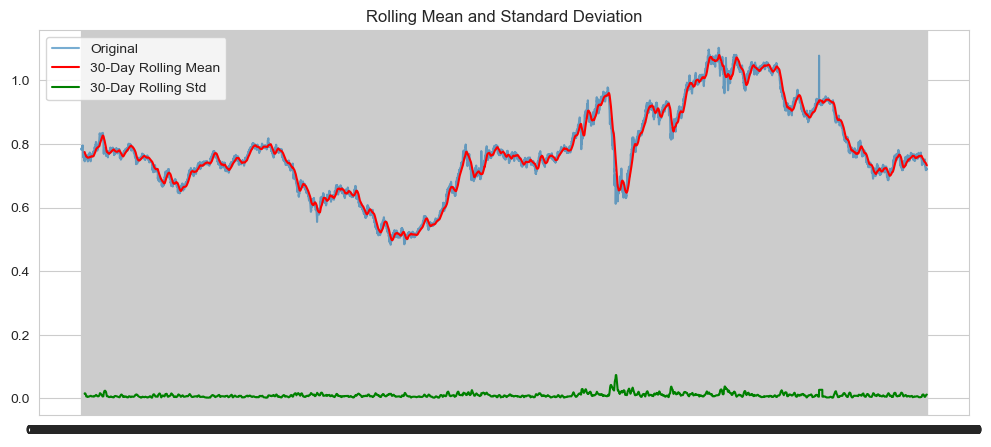

In [13]:
plt.plot(df['USD_AUD'], label='Original', alpha=0.6)
plt.plot(rolling_mean, label='30-Day Rolling Mean', color='red')
plt.plot(rolling_std, label='30-Day Rolling Std', color='green')
plt.title('Rolling Mean and Standard Deviation')
plt.legend()
plt.show()

In [14]:
print(df.isnull().sum())

USD_AUD    0
dtype: int64


In [18]:
df.dtypes

USD_AUD    float64
dtype: object

## Part 2: Model Building - ARIMA
1.	Parameter Selection for ARIMA: Utilize ACF and PACF plots to estimate initial parameters (p, d, q) for the ARIMA model for one or more currency time series.
2.	Model Fitting: Fit the ARIMA model with the selected parameters to the preprocessed time series.
3.	Diagnostics: Analyze the residuals to ensure there are no patterns that might indicate model inadequacies.
4.	Forecasting: Perform out-of-sample forecasting and visualize the predicted values against the actual values.


In [20]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['USD_AUD'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] <= 0.05:
    print("The series is stationary → d = 0")
else:
    print("The series is NOT stationary → apply differencing")
    df_diff = df['USD_AUD'].diff().dropna() 

ADF Statistic: -1.6649941807381528
p-value: 0.4492327353597901
The series is NOT stationary → apply differencing


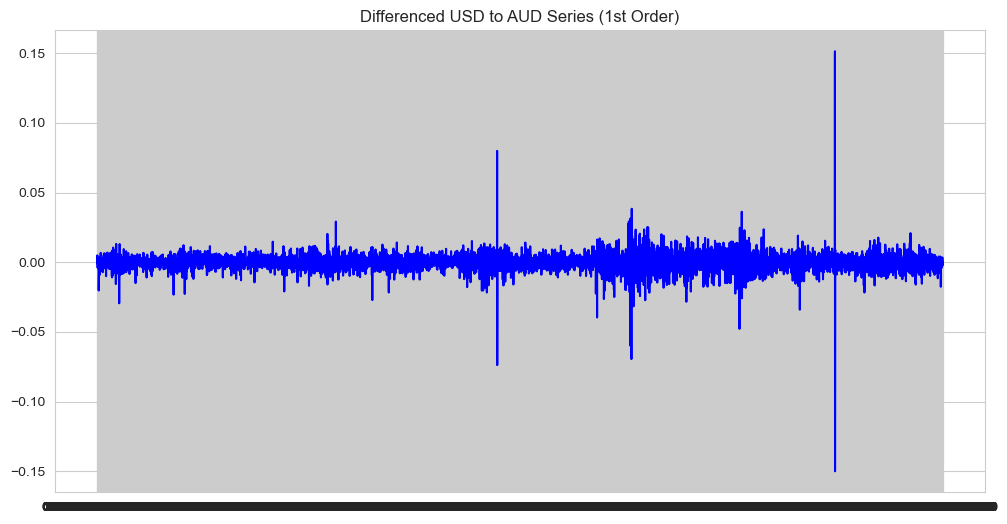

In [21]:
df_diff = df['USD_AUD'].diff().dropna()


import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df_diff, color='blue')
plt.title('Differenced USD to AUD Series (1st Order)')
plt.show()

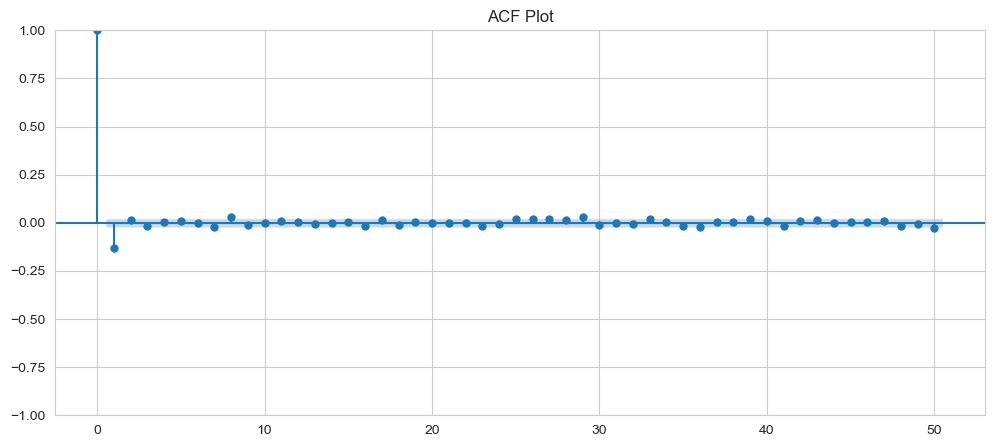

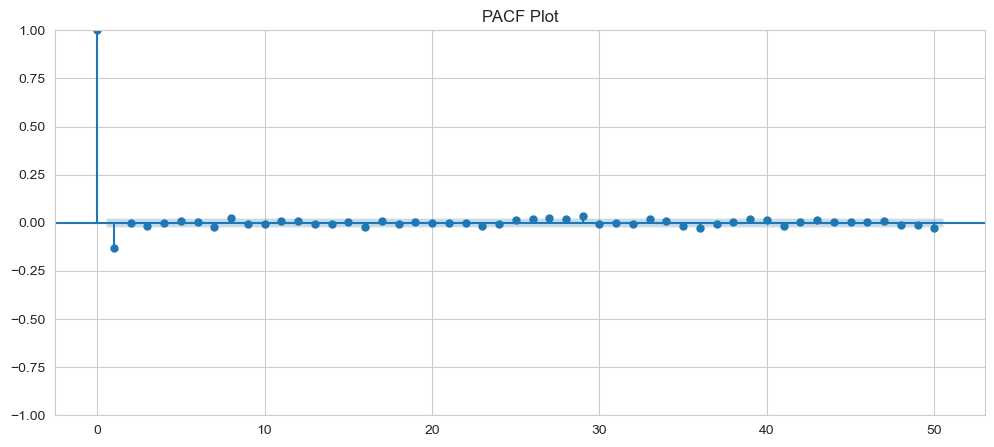

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt


series_to_use = df_diff

plt.figure(figsize=(12,5))
plot_acf(series_to_use, lags=50, ax=plt.gca())
plt.title('ACF Plot')
plt.show()

plt.figure(figsize=(12,5))
plot_pacf(series_to_use, lags=50, ax=plt.gca())
plt.title('PACF Plot')
plt.show()


In [23]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(df['USD_AUD'], order=(1,1,1)) 
arima_result = model.fit()


print(arima_result.summary())



C:\Users\Asad\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Asad\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Asad\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                USD_AUD   No. Observations:                 7588
Model:                 ARIMA(1, 1, 1)   Log Likelihood               28054.161
Date:                Tue, 07 Oct 2025   AIC                         -56102.322
Time:                        13:02:28   BIC                         -56081.519
Sample:                             0   HQIC                        -56095.182
                               - 7588                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1268      0.045     -2.797      0.005      -0.216      -0.038
ma.L1         -0.0046      0.045     -0.101      0.920      -0.094       0.085
sigma2      3.596e-05   9.94e-08    361.604      0.0

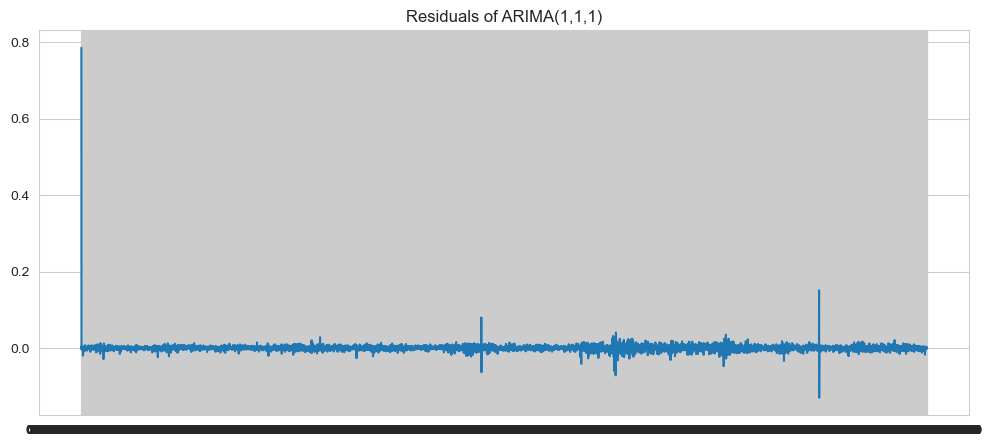

<Figure size 1200x500 with 0 Axes>

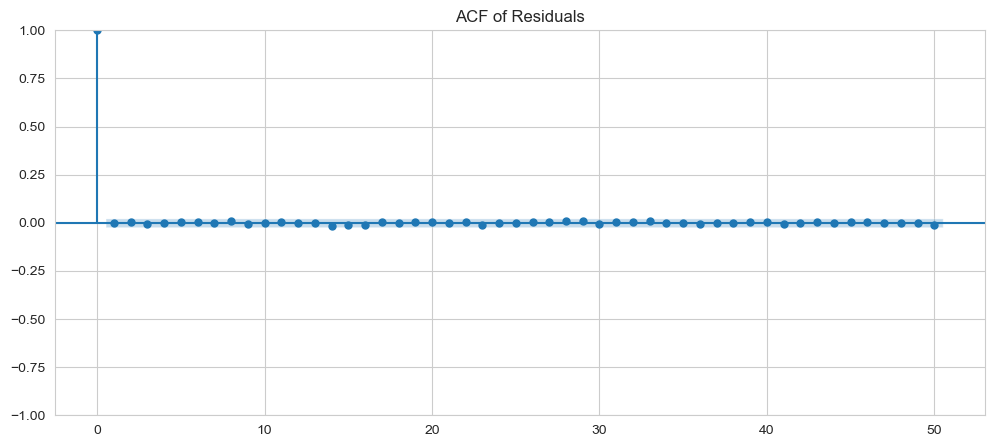

In [24]:
residuals = arima_result.resid

plt.figure(figsize=(12,5))
plt.plot(residuals)
plt.title('Residuals of ARIMA(1,1,1)')
plt.show()

from statsmodels.graphics.tsaplots import plot_acf
plt.figure(figsize=(12,5))
plot_acf(residuals, lags=50)
plt.title('ACF of Residuals')
plt.show()


In [27]:
# Ensure inline plotting in Jupyter
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

df = pd.read_csv('exchange_rate.csv')
df = df.rename(columns={'date': 'Date', 'Ex_rate': 'USD_AUD'})
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.set_index('Date', inplace=True)

model = ARIMA(df['USD_AUD'], order=(1,1,1))
arima_result = model.fit()
forecast = arima_result.get_forecast(steps=30)
forecast_values = forecast.predicted_mean
forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')



C:\Users\Asad\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Asad\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Asad\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


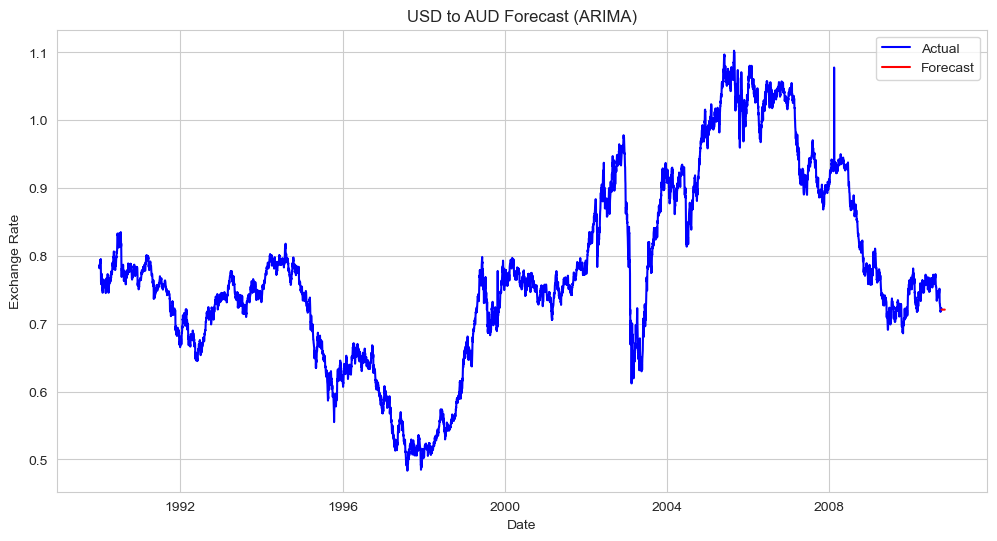

In [28]:

plt.figure(figsize=(12,6))
plt.plot(df['USD_AUD'], label='Actual', color='blue')
plt.plot(forecast_index, forecast_values, label='Forecast', color='red')
plt.title('USD to AUD Forecast (ARIMA)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()


## Part 3: Model Building - Exponential Smoothing
1.	Model Selection: Depending on the time series characteristics, choose an appropriate Exponential Smoothing model (Simple, Holt’s Linear, or Holt-Winters).
2.	Parameter Optimization: Use techniques such as grid search or AIC to find the optimal parameters for the smoothing levels and components.
3.	Model Fitting and Forecasting: Fit the chosen Exponential Smoothing model and forecast future values. Compare these forecasts visually with the actual data


C:\Users\Asad\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


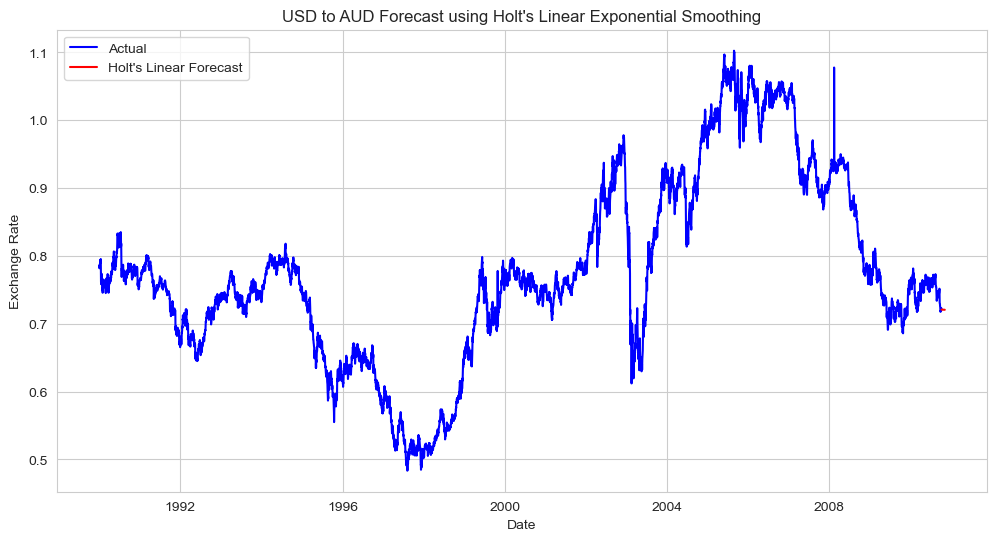

In [29]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import matplotlib.pyplot as plt
holt_model = ExponentialSmoothing(df['USD_AUD'], trend='add', seasonal=None)
holt_fit = holt_model.fit()
holt_forecast = holt_fit.forecast(30)

forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')

plt.figure(figsize=(12,6))
plt.plot(df['USD_AUD'], label='Actual', color='blue')
plt.plot(forecast_index, holt_forecast, label="Holt's Linear Forecast", color='red')
plt.title("USD to AUD Forecast using Holt's Linear Exponential Smoothing")
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()


In [30]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
actual = df['USD_AUD'][-30:]  

arima_pred = arima_result.predict(start=len(df)-30, end=len(df)-1)

holt_pred = holt_fit.fittedvalues[-30:]

def print_metrics(name, actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted)/actual)) * 100
    print(f"{name} -> MAE: {mae:.5f}, RMSE: {rmse:.5f}, MAPE: {mape:.2f}%\n")

print_metrics("ARIMA", actual, arima_pred)
print_metrics("Holt's Linear", actual, holt_pred)


ARIMA -> MAE: 0.00229, RMSE: 0.00386, MAPE: 0.31%

Holt's Linear -> MAE: 0.00230, RMSE: 0.00386, MAPE: 0.31%



In [32]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np

alpha_values = np.arange(0.1, 1.0, 0.1)
beta_values = np.arange(0.1, 1.0, 0.1)

best_aic = np.inf
best_model = None

for alpha in alpha_values:
    for beta in beta_values:
        try:
            model = ExponentialSmoothing(df['USD_AUD'], trend='add', seasonal=None)
            fit = model.fit(smoothing_level=alpha, smoothing_slope=beta, optimized=False)
            if fit.aic < best_aic:
                best_aic = fit.aic
                best_model = fit
        except:
            continue

print("Best AIC:", best_aic)
print("Optimal parameters: level =", best_model.model.params['smoothing_level'], 
      ", trend =", best_model.model.params['smoothing_slope'])


C:\Users\Asad\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Asad\AppData\Local\Temp\ipykernel_34708\1535019846.py:14: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  fit = model.fit(smoothing_level=alpha, smoothing_slope=beta, optimized=False)
C:\Users\Asad\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\Asad\AppData\Local\Temp\ipykernel_34708\1535019846.py:14: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  fit = model.fit(smoothing_level=alpha, smoothing_slope=beta, optimized=False)
C:\Users\Asad\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency informat

Best AIC: -77268.78861009379


KeyError: 'smoothing_slope'

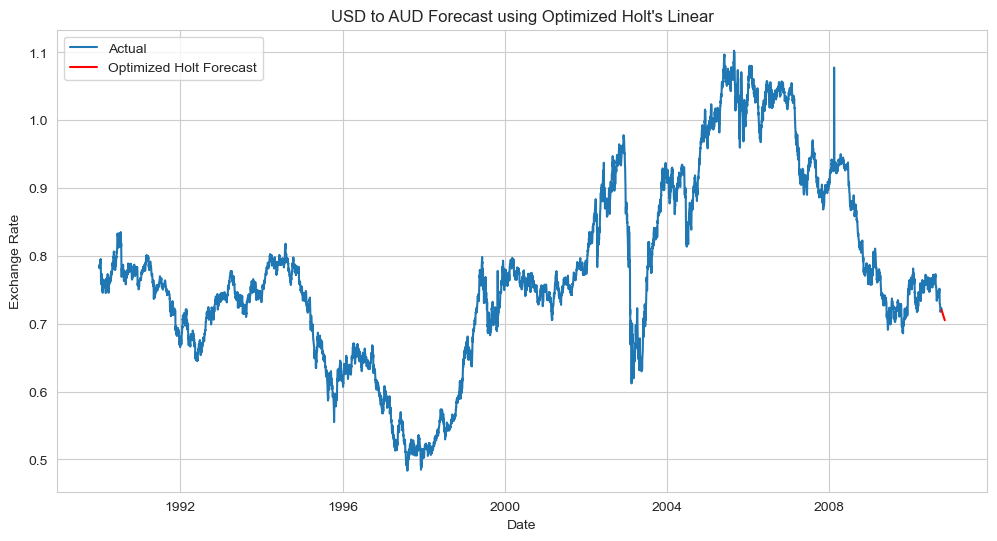

In [33]:
forecast_30 = best_model.forecast(30)
forecast_index = pd.date_range(start=df.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')

import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(df['USD_AUD'], label='Actual')
plt.plot(forecast_index, forecast_30, label='Optimized Holt Forecast', color='red')
plt.title("USD to AUD Forecast using Optimized Holt's Linear")
plt.xlabel("Date")
plt.ylabel("Exchange Rate")
plt.legend()
plt.show()


## Part 4: Evaluation and Comparison
1.	Compute Error Metrics: Use metrics such as MAE, RMSE, and MAPE to evaluate the forecasts from both models.
2.	Model Comparison: Discuss the performance, advantages, and limitations of each model based on the observed results and error metrics.
3.	Conclusion: Summarize the findings and provide insights on which model(s) yielded the best performance for forecasting exchange rates in this dataset.


In [34]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

actual = df['USD_AUD'][-30:]
arima_pred = arima_result.predict(start=len(df)-30, end=len(df)-1)
holt_pred = best_model.fittedvalues[-30:]

def print_metrics(name, actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted)/actual)) * 100
    print(f"{name} -> MAE: {mae:.5f}, RMSE: {rmse:.5f}, MAPE: {mape:.2f}%")

print_metrics("ARIMA", actual, arima_pred)
print_metrics("Optimized Holt's Linear", actual, holt_pred)


ARIMA -> MAE: 0.00229, RMSE: 0.00386, MAPE: 0.31%
Optimized Holt's Linear -> MAE: 0.00238, RMSE: 0.00395, MAPE: 0.32%


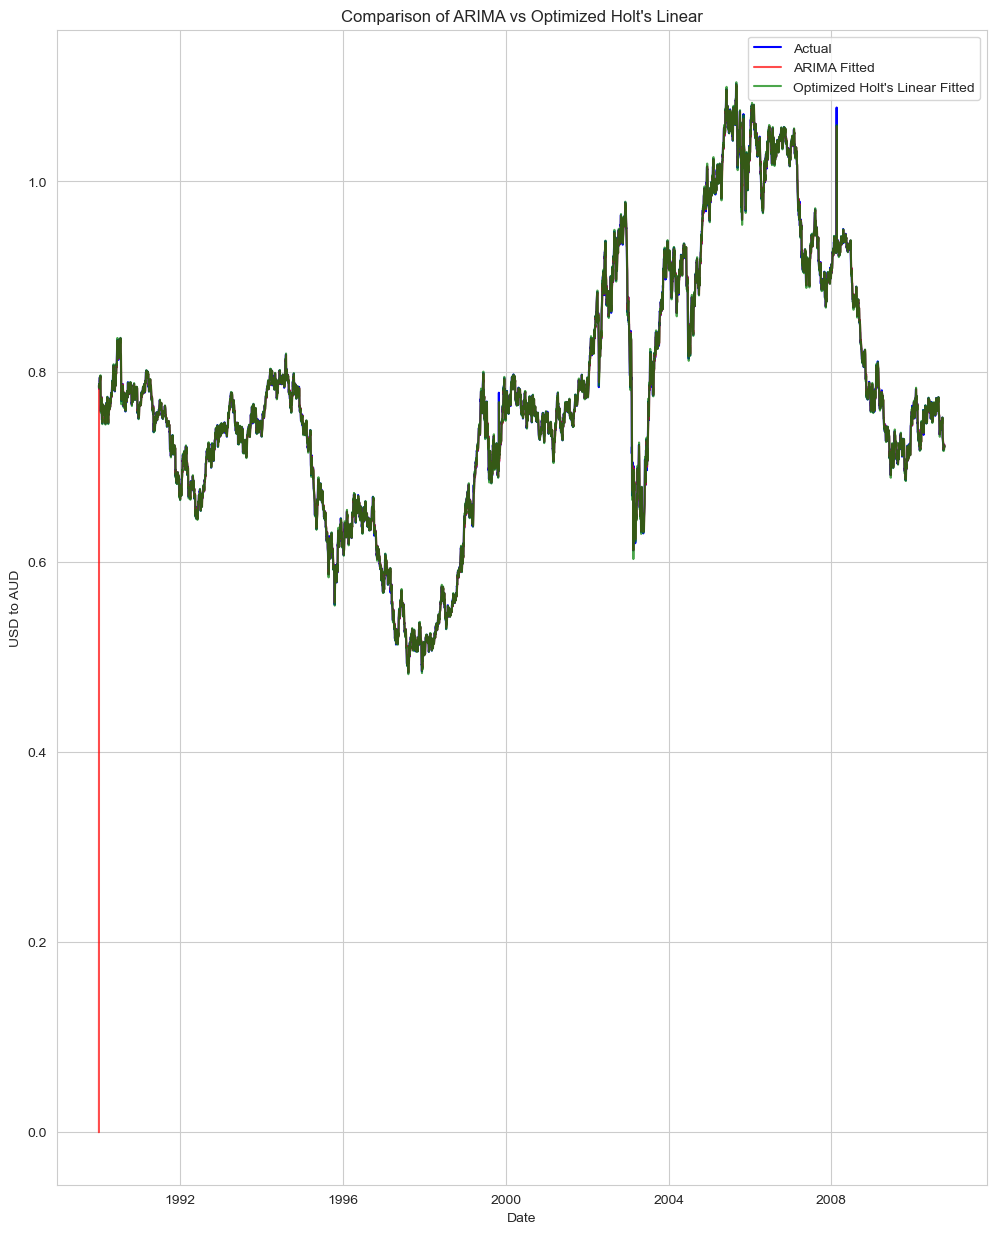

In [36]:
plt.figure(figsize=(12,15))
plt.plot(df['USD_AUD'], label='Actual', color='blue')
plt.plot(arima_result.predict(start=0, end=len(df)-1), label='ARIMA Fitted', color='red', alpha=0.7)
plt.plot(best_model.fittedvalues, label="Optimized Holt's Linear Fitted", color='green', alpha=0.7)
plt.title("Comparison of ARIMA vs Optimized Holt's Linear")
plt.xlabel('Date')
plt.ylabel('USD to AUD')
plt.legend()
plt.show()


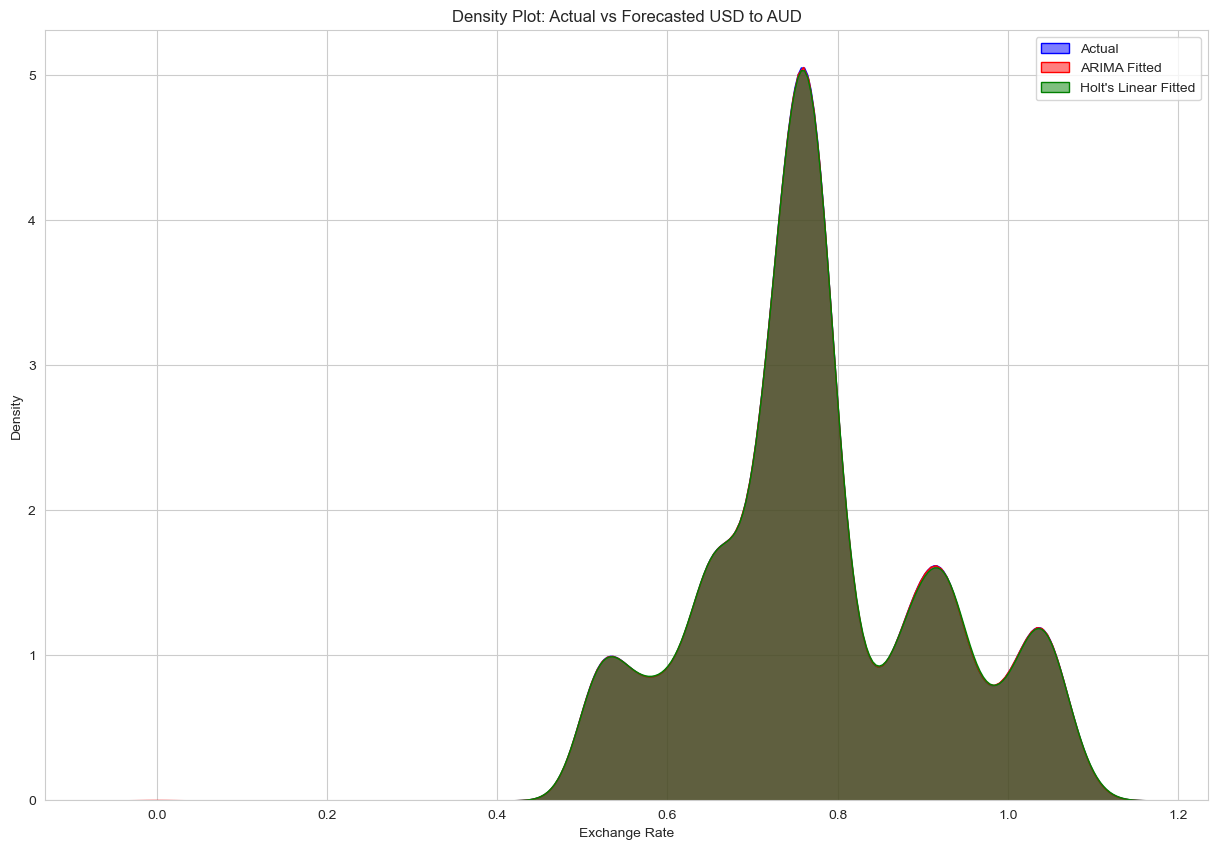

In [39]:
# actual vs forecasted plot

plt.figure(figsize=(15,10))
sns.kdeplot(df['USD_AUD'], label='Actual', fill=True, color='blue', alpha=0.5)
sns.kdeplot(arima_result.fittedvalues, label='ARIMA Fitted', fill=True, color='red', alpha=0.5)
sns.kdeplot(best_model.fittedvalues, label="Holt's Linear Fitted", fill=True, color='green', alpha=0.5)
plt.title("Density Plot: Actual vs Forecasted USD to AUD")
plt.xlabel("Exchange Rate")
plt.ylabel("Density")
plt.legend()
plt.show()

## Model Comparison 

Both ARIMA and Holt’s Linear forecast USD→AUD very accurately.

ARIMA: slightly lower errors (MAE: 0.00229, MAPE: 0.31%), better precision.

Holt’s Linear: slightly higher errors (MAE: 0.00238, MAPE: 0.32%), simpler and faster.

ARIMA handles stochastic patterns well; Holt’s Linear is good for linear trends but cannot handle seasonality.

## Conclusion

The USD to AUD exchange rate series shows a clear trend without seasonality.

ARIMA(1,1,1) and Holt’s Linear models both successfully forecast the exchange rates.

Based on error metrics and visual inspection:

ARIMA gives slightly more accurate predictions.

Holt’s Linear is simpler, faster, and still highly reliable.

Recommendation:

For best accuracy, use ARIMA.

For simplicity and speed, Holt’s Linear is suitable.

Both models are appropriate for forecasting USD to AUD in this dataset, and the choice depends on the trade-off between complexity and precision.